In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib.transforms import Bbox
import seaborn as sns
import scanpy as sc
import scipy
import sklearn

from importlib import reload

import plotting as plt2

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/HSC/scanpy/hsc_landscape.anndata.h5ad"

adata = sc.read_h5ad(fpath)
sc.logging.print_memory_usage()

adata

Memory usage: current 8.75 GB, difference +8.75 GB


AnnData object with n_obs × n_vars = 54347 × 19070
    obs: 'n_counts', 'cell_type', 'dataset', 'organ_tissue', 'n_genes', 'new_cluster', 'cell_label', 'cluster_str', 'UMAP 1', 'UMAP 2'
    var: 'gene_name', 'ensemble_id', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'B_mem', 'B_naive', 'Baso', 'DC', 'Endo', 'Eos', 'Ery', 'Fibro', 'HSC', 'Macro', 'Mega', 'Mono', 'MDSC', 'Neut', 'Osteo', 'Plasma', 'pDC', 'Retic', 'Stromal', 'cluster_genes'
    uns: 'cell_type_colors', 'dataset_colors', 'go_annotations', 'hvg', 'log1p', 'neighbors', 'new_cluster', 'new_cluster_colors', 'organ_tissue_colors', 'panglaodb', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'log_norm', 'raw_counts'
    obsp: 'connectivities', 'distances'

In [3]:
cell_types = ['HSC', 'iHSC']
pdf = adata[adata.obs['cell_type'].isin(cell_types), :]


pdf.obs['dataset'].value_counts()

dataset
iHSC              8574
young2_HSC        3243
pellin            1282
old2_BMMC_HSPC     945
old1_BMMC_HSPC     328
Name: count, dtype: int64

In [4]:
cell_types = {
    "HSC": "Hematopoietic stem cells",
}

pang = pdf.uns['panglaodb'].copy()

for k, v in cell_types.items():
    
    genes = pang[pang['cell_type'] == v]['gene_name'].values
    pdf.var[k] = pdf.var['gene_name'].isin(genes)
    
    exp_genes = pdf.var[pdf.var[k]]['gene_name']
    print(f"{v} ({k}): {len(exp_genes)} genes")

    
# add the flag to the var dataframe
pdf.var['cluster_genes'] = pdf.var[list(cell_types.keys())].any(axis=1)
pdf.var['cluster_genes'].value_counts()

/tmp/ipykernel_3581745/590296814.py:10: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  pdf.var[k] = pdf.var['gene_name'].isin(genes)


Hematopoietic stem cells (HSC): 88 genes


cluster_genes
False    18982
True        88
Name: count, dtype: int64

In [5]:
pang = pdf.uns['panglaodb'].copy()

marker_genes = pang[pang['cell_type'] == v]['gene_name'].to_list()
GO_genes = pdf.uns['go_annotations']['gene_name'].to_list()

pdf.var['hsc_cluster_genes'] = pdf.var['gene_name'].isin(marker_genes + GO_genes)
pdf.var['hsc_cluster_genes'].value_counts()

hsc_cluster_genes
False    18925
True       145
Name: count, dtype: int64

Performing PCA dimensionality reduction...


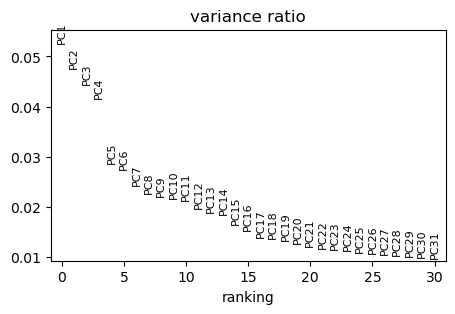

In [6]:
# PCA Analysis
print("Performing PCA dimensionality reduction...")
sc.pp.pca(
    pdf, 
    n_comps=50, 
    mask_var='hsc_cluster_genes',
)

plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = 5, 3
sc.pl.pca_variance_ratio(
    pdf, 
)

Calculating nearest neighbors...
Computing UMAP embedding...
Running Leiden clustering algorithm...

Cluster distribution:
hsc_cluster
0     2856
1     2117
2     1800
3     1792
4     1495
5     1210
6      934
7      824
8      361
9      303
10     268
11     223
12     189
Name: count, dtype: int64


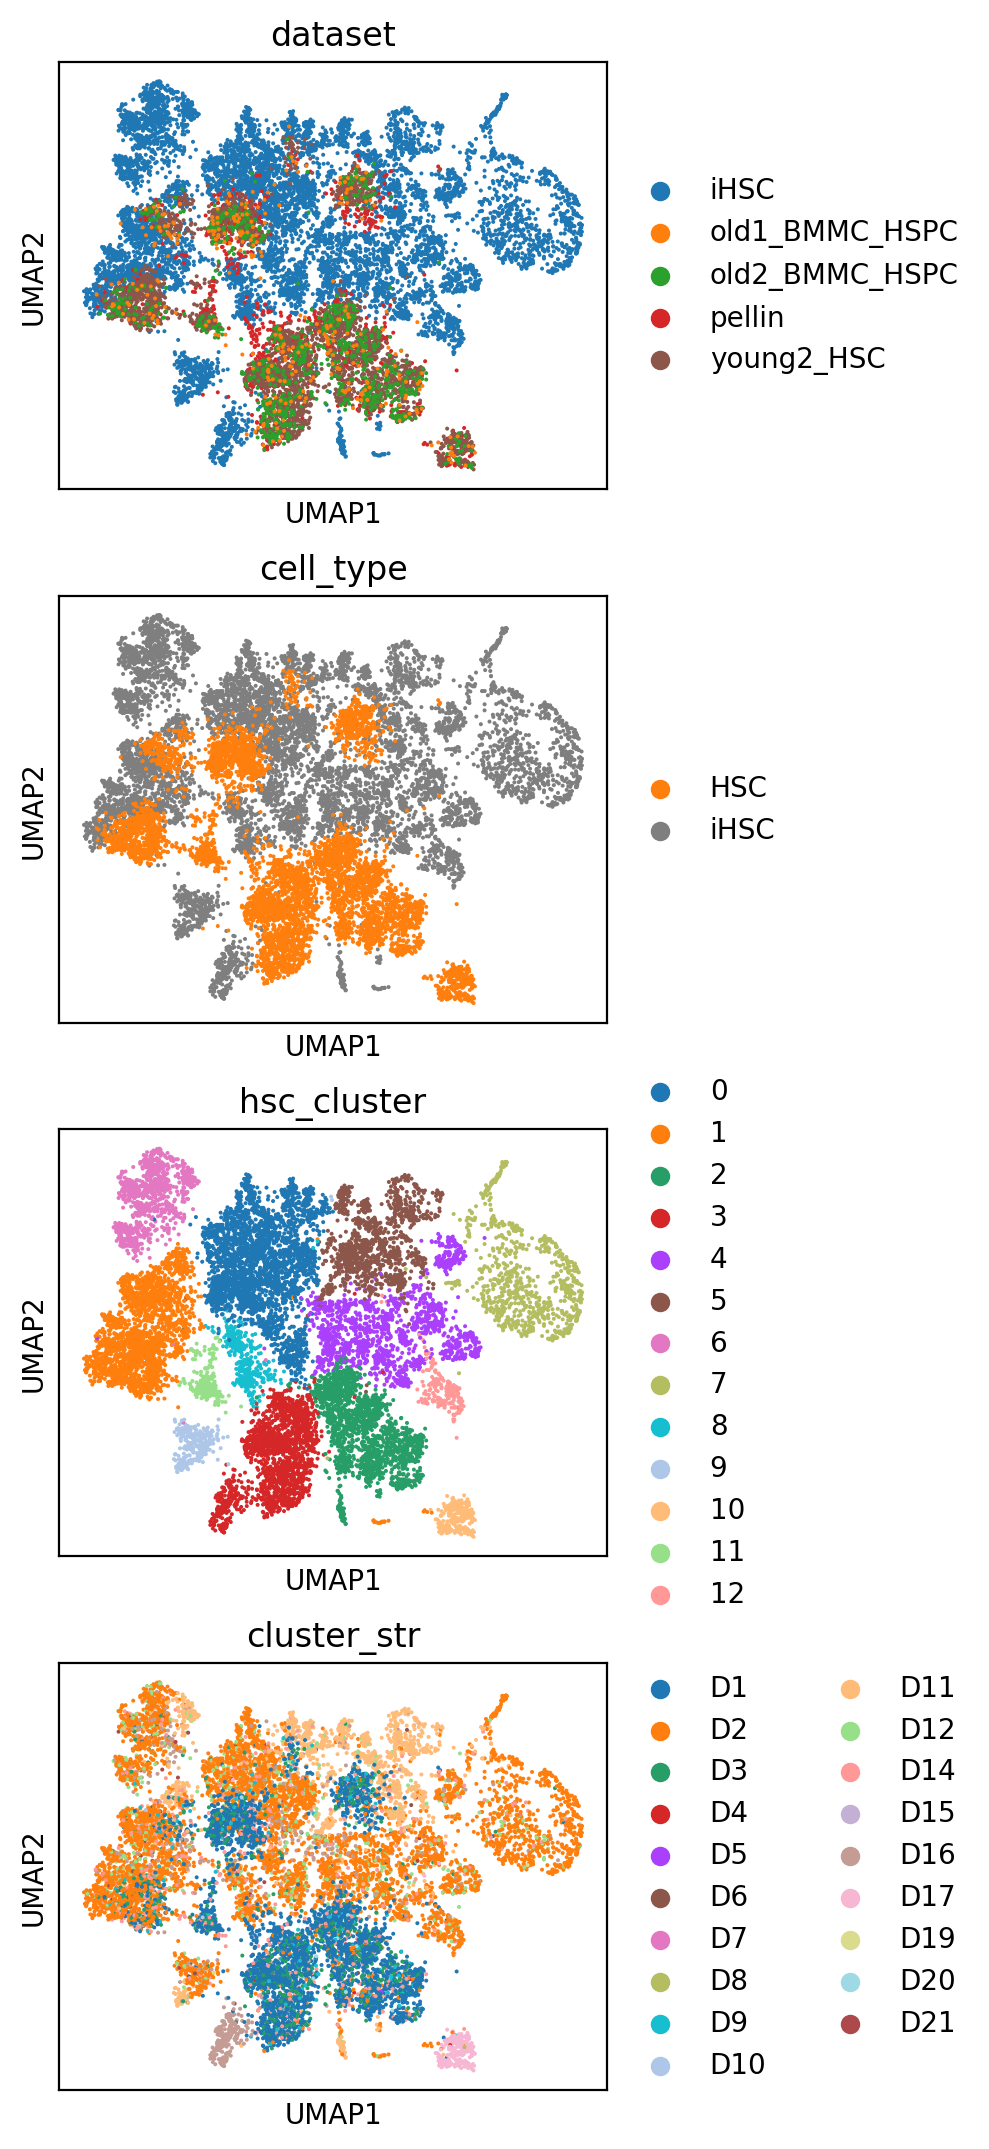

,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,hsc_cluster,hsc_cluster_str
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,-1.848881,3.908249,0,H1
AAACCCAAGTTGAAGT_iHSC,5488.0,iHSC,iHSC,nan,12413,1,Reprogrammed Cells,D2,-7.352784,5.908605,6,H7
AAACCCAAGTTGTCGT_iHSC,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,0.002043,4.933716,0,H1
AAACCCACAGAAGCGT_iHSC,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,0.917834,7.406786,0,H1
AAACCCACAGGAGGTT_iHSC,14427.0,iHSC,iHSC,nan,13436,1,Reprogrammed Cells,D2,-3.470557,-2.704370,9,H10


In [26]:
# Calculate Nearest Neighbors
print("Calculating nearest neighbors...")
sc.pp.neighbors(
    pdf,
    n_pcs=20, # approximate effective rank from above
    n_neighbors=15,
)

# UMAP Embedding
print("Computing UMAP embedding...")
sc.tl.umap(
    pdf,
    min_dist=0.5,
)

# Leiden Clustering
print("Running Leiden clustering algorithm...")
sc.tl.leiden(
    pdf, 
    resolution=0.2, 
    directed=True,
    key_added='hsc_cluster',
)

# Optionally, you can add a print statement to inspect the clusters:
print("\nCluster distribution:")
print(pdf.obs['hsc_cluster'].value_counts())

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3
# Plot it!
sc.pl.umap(
    pdf,
    color=['dataset','cell_type','hsc_cluster',],
    ncols=1,
)

pdf.obs['hsc_cluster_str'] = pdf.obs['hsc_cluster'].apply(lambda x: "H" + str(int(x) + 1))

pdf.obs['UMAP 1'] = pdf.obsm['X_umap'][:, 0]
pdf.obs['UMAP 2'] = pdf.obsm['X_umap'][:, 1]

pdf.obs.head()

# Nice plots

,n_counts,cell_type,dataset,organ_tissue,n_genes,new_cluster,cell_label,cluster_str,UMAP 1,UMAP 2,hsc_cluster,hsc_cluster_str
AAACCCAAGGTTACCT_iHSC,6558.0,iHSC,iHSC,nan,12480,1,Reprogrammed Cells,D2,-1.848881,3.908249,0,H1
AAACCCAAGTTGAAGT_iHSC,5488.0,iHSC,iHSC,nan,12413,1,Reprogrammed Cells,D2,-7.352784,5.908605,6,H7
AAACCCAAGTTGTCGT_iHSC,4330.0,iHSC,iHSC,nan,11906,10,Reprogrammed Cells,D11,0.002043,4.933716,0,H1
AAACCCACAGAAGCGT_iHSC,3442.0,iHSC,iHSC,nan,11861,10,Reprogrammed Cells,D11,0.917834,7.406786,0,H1
AAACCCACAGGAGGTT_iHSC,14427.0,iHSC,iHSC,nan,13436,1,Reprogrammed Cells,D2,-3.470557,-2.704370,9,H10


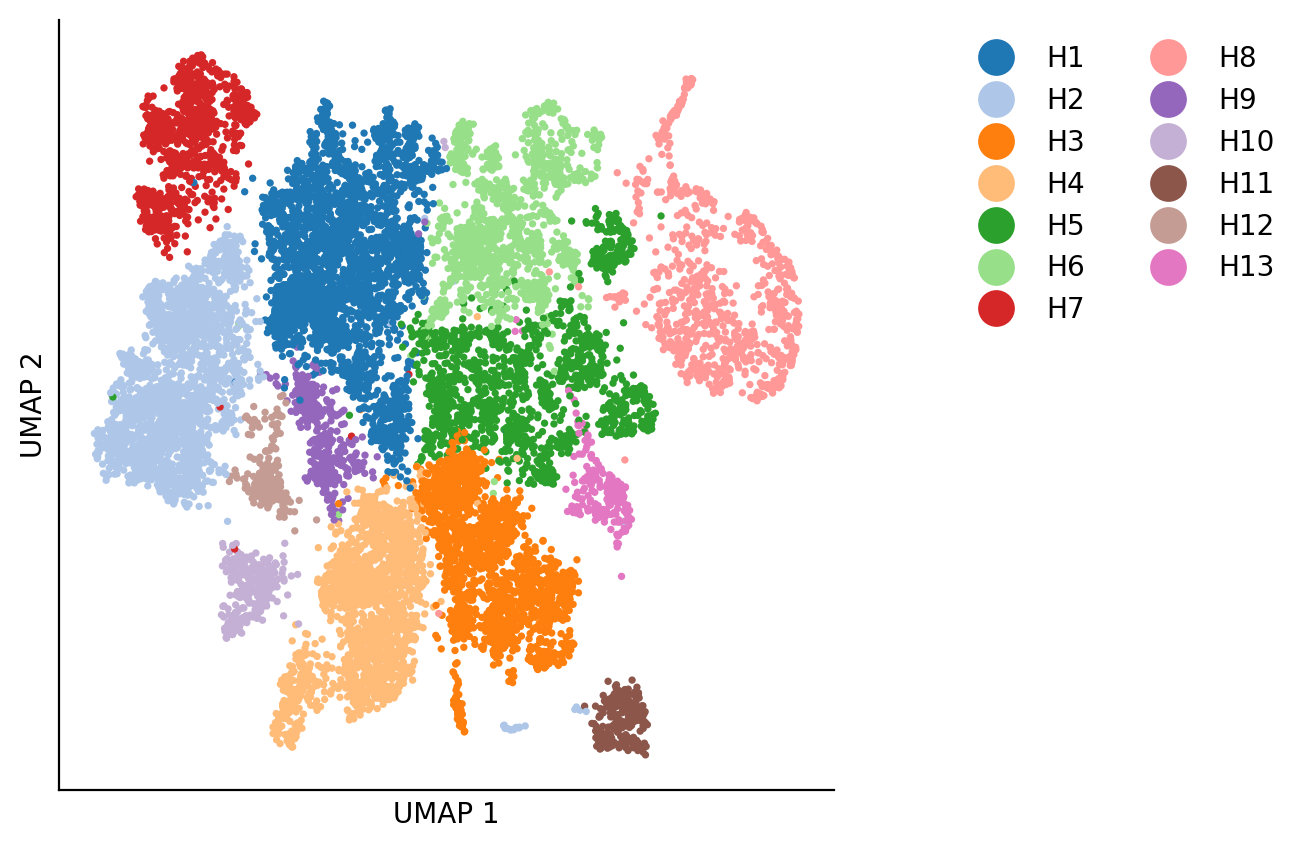

In [8]:
plot = pdf.obs.copy()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 5, 5

sns.scatterplot(
    data=plot,
    x='UMAP 1',
    y='UMAP 2',
    ec='none',
    s=7,
    hue='hsc_cluster_str',
    palette='tab20',
)

plt.xticks([])
plt.yticks([])

plt.ylabel('UMAP 2')
plt.xlabel('UMAP 1')
plt.gca().set_aspect('auto')
sns.despine()
# plt.axis(False)

sns.move_legend(plt.gca(),
                loc='upper right',
                title="",
                frameon=False,
                bbox_to_anchor=(1.6, 1),
                markerscale=5,
                ncol=2
               )
plot.head()

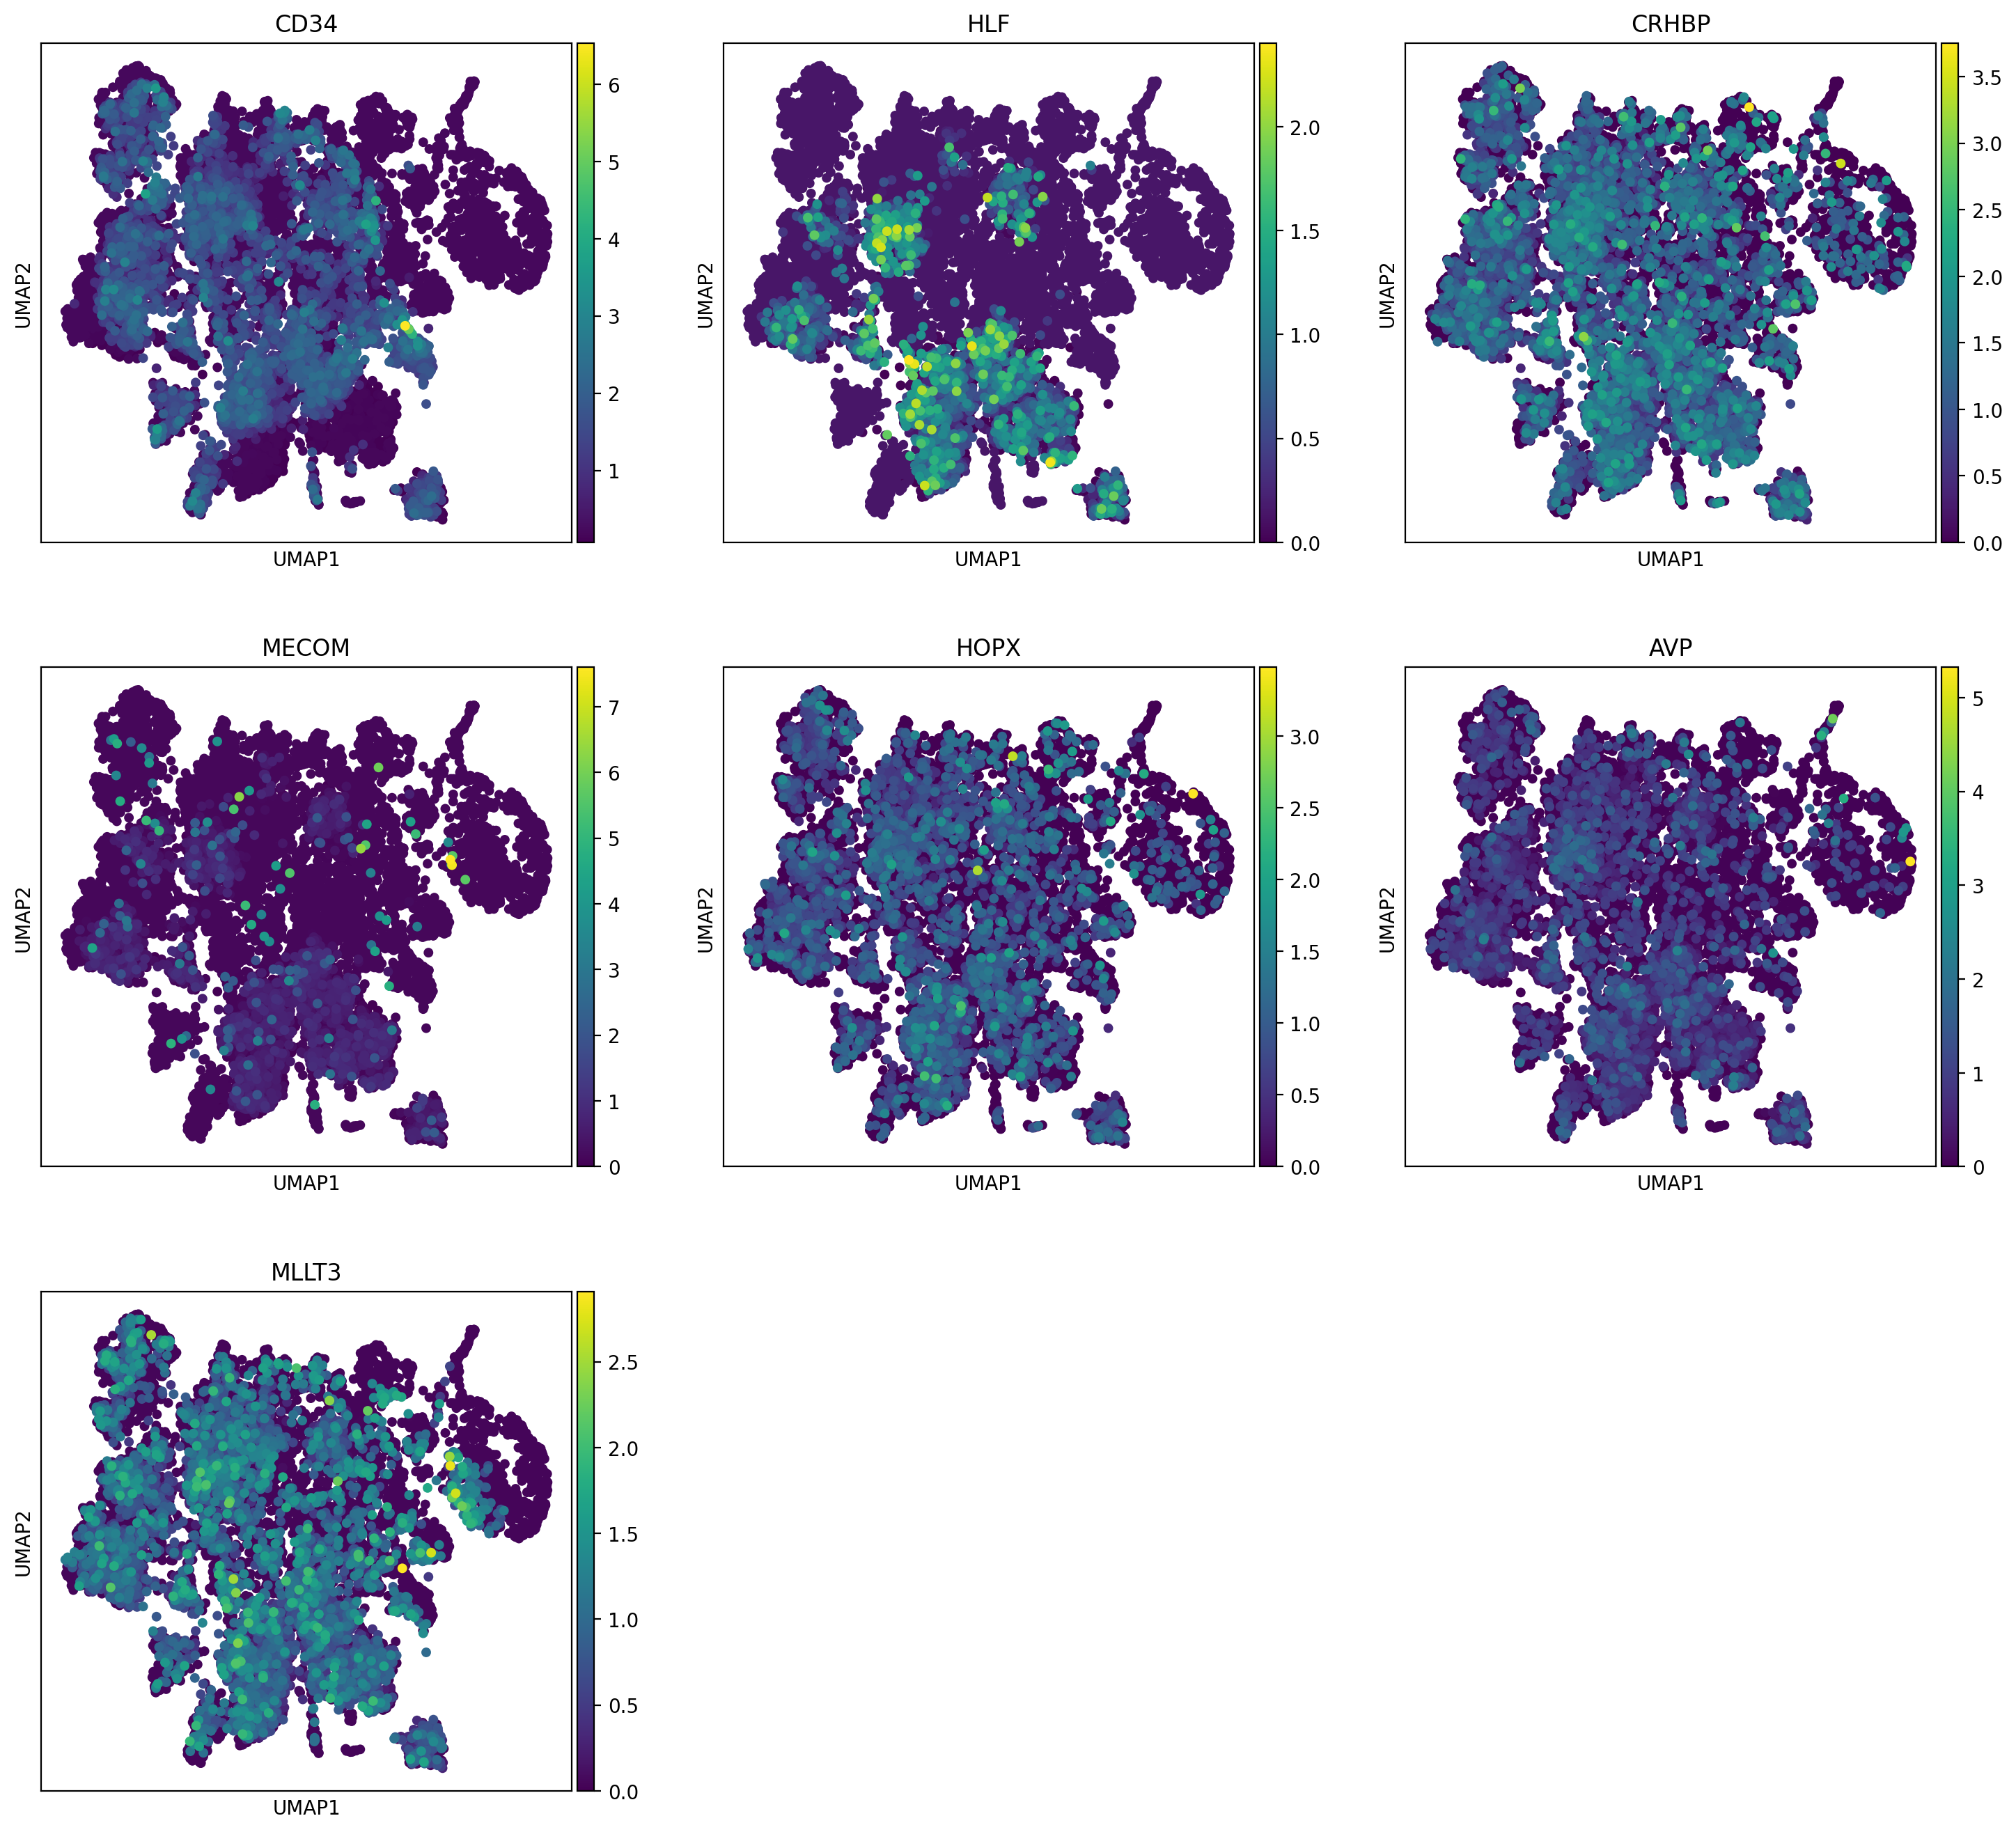

In [20]:
sc.pl.umap(
    pdf,
    color=["CD34", "HLF", "CRHBP", "MECOM", "HOPX", "AVP", "MLLT3"],
    s=100,
    ncols=3,
)

In [ ]:
break

# DEG

In [23]:
sc.tl.rank_genes_groups(
    pdf, 
    groupby="hsc_cluster_str",
    method='wilcoxon',
    corr_method='benjamini-hochberg',
    pts=True,
    key_added='hsc_deg',
)

deg = sc.get.rank_genes_groups_df(
    pdf, 
    group=None,
    key='hsc_deg',
)

deg.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,H1,ZFP36,63.513508,2.518371,0.000000e+00,0.000000e+00,1.0,1.0
1,H1,MEOX1,16.887894,0.584580,5.523938e-64,2.633537e-60,1.0,1.0
2,H1,STEAP1,16.825613,0.044902,1.584132e-63,3.462377e-60,1.0,1.0
3,H1,HCAR3,16.796003,-0.012577,2.610544e-63,3.555934e-60,1.0,1.0
4,H1,C7,16.768837,-0.004133,4.125096e-63,3.973332e-60,1.0,1.0


In [25]:
sig = deg.copy()

alpha = 0.05
sig = sig[sig['pvals_adj'] <= alpha]
sig.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj,pct_nz_group,pct_nz_reference
0,H1,ZFP36,63.513508,2.518371,0.000000e+00,0.000000e+00,1.0,1.0
1,H1,MEOX1,16.887894,0.584580,5.523938e-64,2.633537e-60,1.0,1.0
2,H1,STEAP1,16.825613,0.044902,1.584132e-63,3.462377e-60,1.0,1.0
3,H1,HCAR3,16.796003,-0.012577,2.610544e-63,3.555934e-60,1.0,1.0
4,H1,C7,16.768837,-0.004133,4.125096e-63,3.973332e-60,1.0,1.0
